In [26]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-diabetes').getOrCreate()

In [27]:
df = spark.read.csv('/content/sample_data/diabetes.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [28]:
import pandas as pd

pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
Pregnancies,6.000,1.000,8.000,1.000,0.000
Glucose,148.000,85.000,183.000,89.000,137.000
BloodPressure,72.000,66.000,64.000,66.000,40.000
SkinThickness,35.000,29.000,0.000,23.000,35.000
Insulin,0.000,0.000,0.000,94.000,168.000
BMI,33.600,26.600,23.300,28.100,43.100
DiabetesPedigreeFunction,0.627,0.351,0.672,0.167,2.288
Age,50.000,31.000,32.000,21.000,33.000
Outcome,1.000,0.000,1.000,0.000,1.000


In [29]:
df.toPandas()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [30]:
df.groupby('Outcome').count().toPandas()

,Outcome,count
0,1,268
1,0,500


In [31]:

# checking numerical features
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']

In [32]:
numeric_features

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'Age',
 'Outcome']

In [33]:


df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Pregnancies,768,3.8450520833333335,3.36957806269887,0,17
Glucose,768,120.89453125,31.97261819513622,0,199
BloodPressure,768,69.10546875,19.355807170644777,0,122
SkinThickness,768,20.536458333333332,15.952217567727642,0,99
Insulin,768,79.79947916666667,115.24400235133803,0,846
Age,768,33.240885416666664,11.760231540678689,21,81
Outcome,768,0.3489583333333333,0.476951377242799,0,1


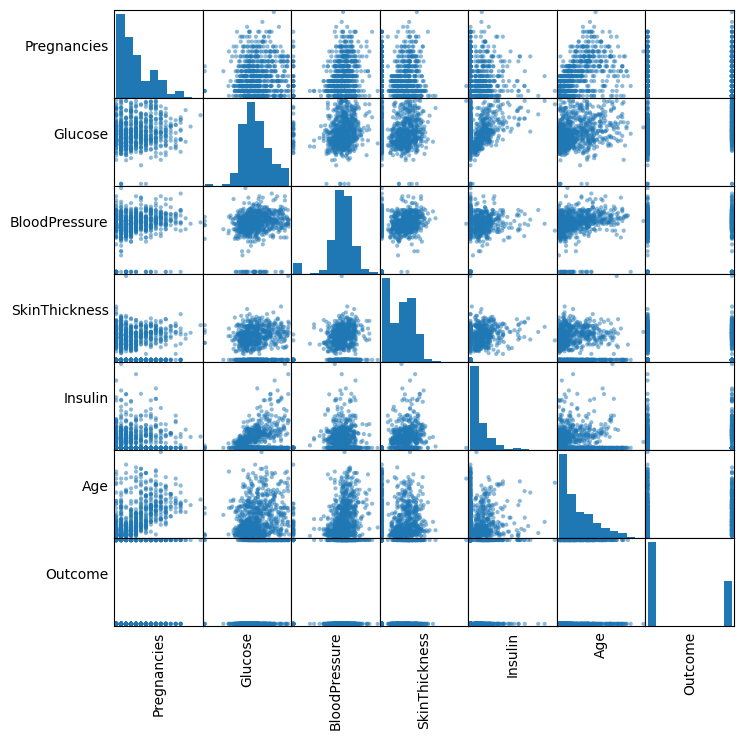

In [34]:
from pandas.plotting import scatter_matrix
numeric_data = df.select(numeric_features).toPandas()
axs=scatter_matrix(numeric_data, figsize=(8,8))
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [35]:
from pyspark.sql.functions import isnull, when, count, col

df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



In [36]:
dataset = df.drop('SkinThickness')
dataset = dataset.drop('Insulin')
dataset_new = dataset.drop('DiabetesPedigreeFunction')
dataset_final = dataset_new.drop('Pregnancies')

dataset_final.show()

+-------+-------------+----+---+-------+
|Glucose|BloodPressure| BMI|Age|Outcome|
+-------+-------------+----+---+-------+
|    148|           72|33.6| 50|      1|
|     85|           66|26.6| 31|      0|
|    183|           64|23.3| 32|      1|
|     89|           66|28.1| 21|      0|
|    137|           40|43.1| 33|      1|
|    116|           74|25.6| 30|      0|
|     78|           50|31.0| 26|      1|
|    115|            0|35.3| 29|      0|
|    197|           70|30.5| 53|      1|
|    125|           96| 0.0| 54|      1|
|    110|           92|37.6| 30|      0|
|    168|           74|38.0| 34|      1|
|    139|           80|27.1| 57|      0|
|    189|           60|30.1| 59|      1|
|    166|           72|25.8| 51|      1|
|    100|            0|30.0| 32|      1|
|    118|           84|45.8| 31|      1|
|    107|           74|29.6| 31|      1|
|    103|           30|43.3| 33|      0|
|    115|           70|34.6| 32|      1|
+-------+-------------+----+---+-------+
only showing top

In [37]:
required_features = ['Glucose', 'BloodPressure', 'BMI', 'Age']

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=required_features, outputCol='features')

transformed_data = assembler.transform(dataset_final)
transformed_data.show()


+-------+-------------+----+---+-------+--------------------+
|Glucose|BloodPressure| BMI|Age|Outcome|            features|
+-------+-------------+----+---+-------+--------------------+
|    148|           72|33.6| 50|      1|[148.0,72.0,33.6,...|
|     85|           66|26.6| 31|      0|[85.0,66.0,26.6,3...|
|    183|           64|23.3| 32|      1|[183.0,64.0,23.3,...|
|     89|           66|28.1| 21|      0|[89.0,66.0,28.1,2...|
|    137|           40|43.1| 33|      1|[137.0,40.0,43.1,...|
|    116|           74|25.6| 30|      0|[116.0,74.0,25.6,...|
|     78|           50|31.0| 26|      1|[78.0,50.0,31.0,2...|
|    115|            0|35.3| 29|      0|[115.0,0.0,35.3,2...|
|    197|           70|30.5| 53|      1|[197.0,70.0,30.5,...|
|    125|           96| 0.0| 54|      1|[125.0,96.0,0.0,5...|
|    110|           92|37.6| 30|      0|[110.0,92.0,37.6,...|
|    168|           74|38.0| 34|      1|[168.0,74.0,38.0,...|
|    139|           80|27.1| 57|      0|[139.0,80.0,27.1,...|
|    189

In [38]:
(training_data, test_data) = transformed_data.randomSplit([0.8,0.2])

print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 612
Test Dataset Count: 156


In [39]:
from pyspark.ml.classification import DecisionTreeClassifier
dt= DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Outcome', maxDepth = 3)
dt5= DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Outcome', maxDepth = 5)
dt7= DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Outcome', maxDepth = 7)
dt9= DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Outcome', maxDepth = 9)


dtModel = dt.fit(training_data)
dtModel5 = dt5.fit(training_data)
dtModel7= dt7.fit(training_data)
dtModel9 = dt9.fit(training_data)

dt_predicy = dtModel.transform(test_data)
dt_predicy5 = dtModel5.transform(test_data)
dt_predicy7 = dtModel7.transform(test_data)
dt_predicy9 = dtModel9.transform(test_data)

dt_predicy.select("prediction", "Outcome", "features").show(10)
dt_predicy5.select("prediction", "Outcome", "features").show(10)
dt_predicy7.select("prediction", "Outcome", "features").show(10)
dt_predicy9.select("prediction", "Outcome", "features").show(10)

+----------+-------+--------------------+
|prediction|Outcome|            features|
+----------+-------+--------------------+
|       0.0|      0|[0.0,48.0,24.7,22.0]|
|       0.0|      1|[0.0,68.0,39.0,41.0]|
|       0.0|      0|[0.0,74.0,27.7,21.0]|
|       0.0|      0|[71.0,48.0,20.4,2...|
|       0.0|      0|[71.0,62.0,21.8,2...|
|       0.0|      0|[74.0,52.0,27.8,2...|
|       0.0|      0|[75.0,82.0,33.3,3...|
|       0.0|      0|[76.0,62.0,34.0,2...|
|       0.0|      0|[78.0,88.0,36.9,2...|
|       0.0|      0|[79.0,80.0,25.4,2...|
+----------+-------+--------------------+
only showing top 10 rows

+----------+-------+--------------------+
|prediction|Outcome|            features|
+----------+-------+--------------------+
|       0.0|      0|[0.0,48.0,24.7,22.0]|
|       0.0|      1|[0.0,68.0,39.0,41.0]|
|       0.0|      0|[0.0,74.0,27.7,21.0]|
|       0.0|      0|[71.0,48.0,20.4,2...|
|       0.0|      0|[71.0,62.0,21.8,2...|
|       0.0|      0|[74.0,52.0,27.8,2...|
|       

In [41]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'Outcome', metricName = 'accuracy')
print('Decision Tree Accuracy depth 3:', multi_evaluator.evaluate(dt_predicy))
print('Decision Tree Accuracy depth 5:', multi_evaluator.evaluate(dt_predicy5))
print('Decision Tree Accuracy depth 7:', multi_evaluator.evaluate(dt_predicy7))
print('Decision Tree Accuracy depth 9:', multi_evaluator.evaluate(dt_predicy9))

Decision Tree Accuracy depth 3: 0.7884615384615384
Decision Tree Accuracy depth 5: 0.7692307692307693
Decision Tree Accuracy depth 7: 0.75
Decision Tree Accuracy depth 9: 0.7051282051282052
